# Threat Detection

In [109]:
# Libraries 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.animation as animation
import matplotlib.cm as cm
import scipy
import scipy.ndimage
import skimage.io
import imageio
import cv2
from skimage import morphology
from matplotlib.patches import Circle
import matplotlib.patches as patches
# plt.rcParams['figure.figsize'] = [20, 20]


### Necessary Functions

#### NCC Template Matching

In [2]:
def getAverageRGBN(image):
  """
  Given np Image, return average value of color as (r, g, b)
  """
  # get image as numpy array
  # get shape
  w,h,d = image.shape
  # change shape
  image = image.reshape(w*h, d)
  # get average
  return (np.mean(image, axis=0))
# NCC
# assume templateDiffs are a cube of differences in x,y,rgb plane
def ncc(templateDiffs, templateStd, patchIm):
    nRGB = templateDiffs.shape[2]
    patchMeans = getAverageRGBN(patchIm)#np.zeros(nRGB)
    patchStd = np.zeros(nRGB)
    nPixels = templateDiffs.shape[0] * templateDiffs.shape[1]
    for color in range(templateDiffs.shape[2]): # get rgb
        patchStd[color] = np.std(patchIm[:,:,color],ddof=1) # unbiased
    NCC = 0
    # get differences, all vectorized because otherwise it's too slow without C mappings.
    patchDiffs = np.zeros(patchIm.shape)
    for c in range(nRGB):
        patchDiffs[:, :, c] = patchIm[:,:,c] - patchMeans[c]
    NCC = np.multiply(patchDiffs, templateDiffs)
    for c in range(nRGB):
      denom = templateStd[c] * patchStd[c] # standard deviation term
      NCC[:,:,c] = np.divide(NCC[:,:,c], denom)
    
    NCC /= (nPixels - 1) 
    NCC = np.sum(NCC)
    return NCC
  
def ncc_scan(im, templateIm):
  windowRows = templateIm.shape[0]
  windowCols = templateIm.shape[1]
  finalOriginRow = im.shape[0] - windowRows + 1
  finalOriginCol = im.shape[1] - windowCols + 1
  bestOriginRow = 0
  bestOriginCol = 0
  bestDistance = -np.Inf
  allNCCs = np.zeros((finalOriginRow, finalOriginCol))
  
  templateMeans = np.zeros(templateIm.shape[2])
  templateStd = np.zeros(templateIm.shape[2])
  templateDiffs = np.zeros(templateIm.shape)
  for color in range(templateIm.shape[2]):
    templateMeans[color] = np.mean(templateIm[:,:,color])
    templateStd[color] = np.std(templateIm[:,:,color],ddof=1)
  for c in range(templateIm.shape[2]):  
    templateDiffs[:,:,c] = templateIm[:,:,c] - templateMeans[c]
  for row in range(finalOriginRow):
      for col in range(finalOriginCol):
          candidatePatch = im[row:(row + windowRows), col:(col+windowCols),:]
          nccScore = ncc(templateDiffs, templateStd, candidatePatch)
          allNCCs[row, col] = nccScore
          if nccScore > bestDistance:
              bestOriginRow = row
              bestOriginCol = col
              bestDistance = nccScore
  return allNCCs, (bestOriginRow, bestOriginCol) # return a matrix of all the distances and best row/col

#### Meanshift Tracking

In [3]:
def pixelFeature(im, row, col): # reminder row = y, column = x
    x = np.zeros(5)
    x[0] = col
    x[1] = row 
    x[2] = im[row,col,0] # R
    x[3] = im[row,col,1] # G
    x[4] = im[row,col,2] # B
    return x

# centerX ~ col, centerY ~ row
def radialDistance(centerX, centerY,x,y):
    return np.sqrt( np.square(centerX - x) + np.square(centerY - y))

# Epanchnikov profile, also again, x is a column, y is a row (BE VERY CAREFUL)
def circularNeighbors(img, x, y, radius):
    neighborhood = [] # we will append and then  return a matrix.
    maxY = y + radius # max row 
    minY = y - radius # minimum row
    maxX = x + radius # maximum col we're seaching
    minX = x - radius # min col
    # in case we run into weird boundaries of images
    minY = int(minY) - 1
    maxY = int(maxY) + 1
    minX = int(minX) - 1
    maxX = int(maxX) + 1
    if minY < 0:
        minY = 0
    if maxY > img.shape[0]:
        maxY = img.shape[0]
    if minX < 0:
        minX = 0
    if maxX > img.shape[1]:
        maxX = img.shape[1]
    
    # note that the way this neighborhood matrix will be sorted from top
    # to bottom, left to right. We do the above to reduce computational time.
    for row in range(minY, maxY): # y are the rows
        for col in range(minX, maxX): # again X are the columns
            if radialDistance(centerX=x,centerY=y,x=col,y=row) < radius:
                # returns <x,y,r,g,b>
                neighborFeatures = pixelFeature(img, row, col)
                neighborhood.append(neighborFeatures)
    neighborhood = np.stack(neighborhood, axis=0)
    return neighborhood

def epKernel(centerX, centerY, x, y, h):
    r = np.sqrt(np.square(centerX - x) + np.square(centerY - y)) / h
    r = np.square(r)
    retVal = 0
    if r < 1:
        retVal = 1 - r
    return retVal

def colorHistogram(X, bins, x, y, h):
    hist = np.zeros((bins,bins,bins)) # CUBE OF BINS for RGB
    binUpperBounds = np.zeros(bins) # vectors of bin bounds for each dimension.
    binLowerBounds = np.zeros(bins) # indexed in a convenient way.
    # compute bin bounds, and since all RGB values are ints, we can >=,<=
    for i in range(bins):
        low = np.floor(255*i/ bins)
        up = np.floor(255*(i+1)/bins)
        binLowerBounds[i] = low
        binUpperBounds[i] = up
        if i > 0:
            binLowerBounds[i]+=1
    # now go through all the pixel values in X, and bin them. 2 for the position x,y
    for i in range(X.shape[0]):
        rgbBins = np.zeros(X.shape[1] - 2) # find out which bin each pixel value goes into
        for bin in range(bins): # indexed as r,g,b
            for color in range(2, X.shape[1]):
                if (X[i,color] >= binLowerBounds[bin]) and (X[i,color] <= binUpperBounds[bin]): 
                    rgbBins[color - 2] = bin # tldr; find bin for rgb colors.
        # once binned, then, add their weighted values given center
        # using Epanechnikov kernel
        # since we defined which ones exist already, we can just add those specifically.
        hist[int(rgbBins[0]), int(rgbBins[1]), int(rgbBins[2])] += epKernel(x,y,X[i,0],X[i,1],h)
    hist /= np.sum(hist) # normalize
    return hist

def meanshiftWeights(X, q_model, p_test, bins):
    w = np.zeros(X.shape[0])
    binUpperBounds = np.zeros(bins) # vectors of bin bounds for each dimension.
    binLowerBounds = np.zeros(bins) # indexed in a convenient way.
    # compute bin bounds, and since all RGB values are ints, we can >=,<=
    for i in range(bins):
        low = np.floor(255*i/ bins)
        up = np.floor(255*(i+1)/bins)
        binLowerBounds[i] = low
        binUpperBounds[i] = up
        if i > 0:
            binLowerBounds[i]+=1
    # now let's compute all the weights and get the exact bin for each X-term
    for i in range(X.shape[0]):
        rgbBins = np.zeros(X.shape[1] - 2) # find out which bin each pixel value goes into
        for bin in range(bins): # indexed as r,g,b
            for color in range(2, X.shape[1]):
                if X[i,color] >= binLowerBounds[bin] and X[i,color] <= binUpperBounds[bin]: 
                    rgbBins[color - 2] = int(bin) # tldr; find bin for rgb colors.
        ratio = q_model[int(rgbBins[0]), int(rgbBins[1]), int(rgbBins[2])]
        ratio /= p_test[int(rgbBins[0]), int(rgbBins[1]), int(rgbBins[2])]
        ratio = np.sqrt(ratio)
        w[i] += ratio
        
    return w  


def mean_shift_track(nextIm, q_model, r, h, initialX, initialY, nIter, epsilon=-1):
    bins = q_model.shape[0]
    # step 1 generate target pu in current frame at y0
    y0 = np.array([initialX, initialY])
    euclideanDistance = 0
    for iter in range(nIter):
        p_X = circularNeighbors(nextIm, y0[0], y0[1], r)
        p_test = colorHistogram(p_X, bins, y0[0], y0[1], h)
        # compute weights wi
        w = meanshiftWeights(p_X, q_model, p_test, bins)
        sumW = np.sum(w)
        # now compute next best location of target
        weightedCoordinates = np.zeros(2)
        for i in range(p_X.shape[0]):
            weightedCoordinates+= w[i] * p_X[i,:2]
        # follow the y1 algorithm
        y1 = weightedCoordinates / sumW
        euclideanDistance = np.linalg.norm(y1 - y0)
        y0 = y1
        # stop if y1 - y0 < epsilon, no epsilon here though.
        if epsilon > 0 and euclideanDistance < epsilon:
            return y0, euclideanDistance
    return y0, euclideanDistance
    
    

### Import Video

In [4]:
cap = cv2.VideoCapture( 'data/karthick_john.MOV')

In [5]:
# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
 
images = []
# Read until video is completed
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  if ret == True:
 
    images.append(frame)
 
  # Break the loop
  else: 
    break
 
# When everything done, release the video capture object
cap.release()
imageio.mimsave('firstVideo.gif', images)

![SegmentLocal](firstVideo.gif "segment")

### Convert to Numpy Array

In [91]:
firstVideo = np.array(images)
print(firstVideo.shape)

(123, 1080, 1920, 3)


### Template Match Detection (NCC) - Overlay a red box around the template

### Meanshift Tracking - Continuously Track After The First Frame

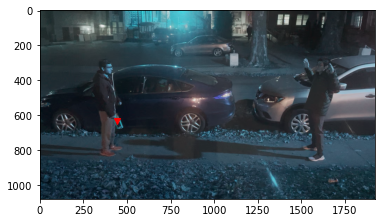

In [34]:
plt.imshow(firstVideo[0])
plt.plot(440, 632, marker='v', color="red")
plt.show()

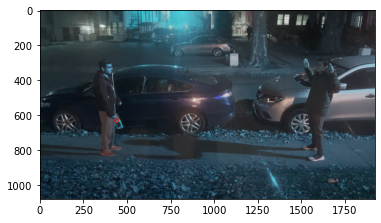

In [159]:
# Create a figure. Equal aspect so circles look circular
fig,ax = plt.subplots(1)
ax.set_aspect('equal')

# Show the image
ax.imshow(firstVideo[0])
circ = Circle((440,632),10, fill=False, color="red")
# rect = patches.Rectangle((430, 612), 50, 70, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(circ)

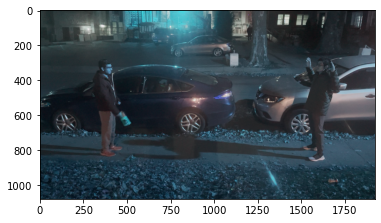

In [25]:
plt.imshow(firstVideo[6])

In [83]:
img1 = firstVideo[0]
img2 = firstVideo[1]
radius = 55
img1CenterX = 444.0 # 
img1CenterY = 642.0 #
bins = 16
h = 55
nIter = 50
pixelX = circularNeighbors(img1, img1CenterX, img1CenterY, radius)
q_model = colorHistogram(pixelX, bins,img1CenterX,img1CenterY,h)
print(pixelX.shape)
print(q_model.shape)

(9465, 5)
(16, 16, 16)


In [84]:
y_best, dist = mean_shift_track(img2, q_model, radius, h, img1CenterX, img1CenterY, 50)

In [85]:
print('Final (X,Y):',y_best)
print('Distance:',dist)

Final (X,Y): [442.47606155 628.18238541]
Distance: 0.03396028888189818


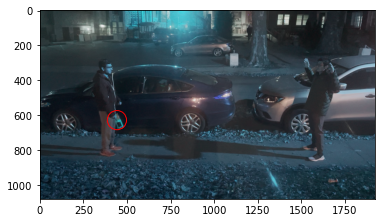

In [87]:
# Create a figure. Equal aspect so circles look circular
fig,ax = plt.subplots(1)
ax.set_aspect('equal')

# Show the image
ax.imshow(firstVideo[1])
circ = Circle((y_best[0],y_best[1]),radius, fill=False, color="red")
ax.add_patch(circ)
plt.savefig('test.png')

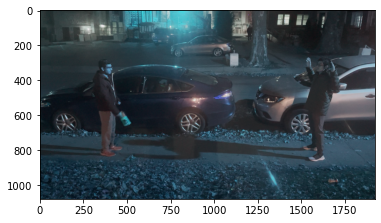

In [54]:
plt.imshow(firstVideo[6])
# plt.plot(y_best[0], y_best[1], marker='v', color="red")
plt.Circle( (y_best[0], y_best[1] ),radius ,fill = False )
plt.show()

In [160]:
img1 = firstVideo[0]
radius = 10
img1CenterX = 440.0 # 
img1CenterY = 632.0 #
bins = 16
h = 10
nIter = 50
pixelX = circularNeighbors(img1, img1CenterX, img1CenterY, radius)
q_model = colorHistogram(pixelX, bins,img1CenterX,img1CenterY,h)
print(pixelX.shape)
print(q_model.shape)

(305, 5)
(16, 16, 16)


In [ ]:
plt_figures = []
for images in range(1,firstVideo.shape[0]):
    img2 = firstVideo[images]
    y_best, dist = mean_shift_track(img2, q_model, radius, h, img1CenterX, img1CenterY, 50)
    print(images)
    fig,ax = plt.subplots(1)
    ax.set_aspect('equal')

    # Show the image
    ax.imshow(img2)
    circ = Circle((y_best[0],y_best[1]),radius, fill=False, color="red")
    ax.add_patch(circ)
    plt.savefig(f'images{images}.png')
    
    #New Model and Center Points
    img1 = img2
    img1CenterX = y_best[0] # 
    img1CenterY = y_best[1] #
    pixelX = circularNeighbors(img1, img1CenterX, img1CenterY, radius)
    q_model = colorHistogram(pixelX, bins,img1CenterX,img1CenterY,h)
    
    
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


/var/folders/0p/t42gq4mx3w7dth53rxp22vyc0000gn/T/ipykernel_43153/805448536.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(1)


22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [137]:
cap = cv2.VideoCapture('data/karthick_john.MOV')

images = []

# take first frame of the video
ret,frame = cap.read()

# setup initial location of window
# r,h,c,w - region of image
#           simply hardcoded the values
r,h,c,w = 612,50,455,50
track_window = (c,r,w,h)


# set up the ROI for tracking
roi = frame[r:r+h, c:c+w]
hsv_roi =  cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
# mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist(images=[hsv_roi],channels=[0],histSize=[180],ranges=[0,180], mask=None)
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while(1):
    ret ,frame = cap.read()

    if ret == True:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # apply meanshift to get the new location
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)

        # Draw it on image
        x,y,w,h = track_window
        img2 = cv2.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        cv2.imshow('img2',img2)

        k = cv2.waitKey(60) & 0xff
        if k == 27:
            break
        else:
            cv2.imwrite(chr(k)+".jpg",img2)

    else:
        break

cv2.destroyAllWindows()
cap.release()

In [ ]:
imageio.mimsave('firstVideo.gif', images)

### Bonus Points, People Detector